In [32]:
import numpy as np
import pandas as pd
import sys
import os
from sklearn.metrics import accuracy_score
import torch
from copy import deepcopy
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from scipy.spatial.distance import pdist, cdist
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(1, os.getenv("NOVA_HOME"))
print(f"NOVA_HOME: {os.getenv('NOVA_HOME')}")

from src.common.utils import load_config_file
from src.datasets.dataset_config import DatasetConfig
from src.datasets.dataset_NOVA import DatasetNOVA
from src.datasets.label_utils import get_markers_from_labels
from src.models.architectures.NOVA_model import NOVAModel
from src.datasets.data_loader import get_dataloader
from src.models.utils.consts import CHECKPOINT_BEST_FILENAME, CHECKPOINTS_FOLDERNAME
from src.embeddings.embeddings_utils import load_embeddings
from src.analysis.analyzer_distances_ari import AnalyzerDistancesARI
%load_ext autoreload
%autoreload 2

NOVA_HOME: /home/projects/hornsteinlab/Collaboration/MOmaps_Noam/MOmaps
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
!$NOVA_HOME

/bin/bash: line 1: /home/projects/hornsteinlab/Collaboration/MOmaps_Noam/MOmaps: Is a directory


In [8]:
output_folder_path = '/home/projects/hornsteinlab/Collaboration/MOmaps/outputs/vit_models/finetuned_model'
config_path_data = './manuscript/distances_config/dNLS345DistanceConfig'
config_data:DatasetConfig = load_config_file(config_path_data, 'data')
config_data.OUTPUTS_FOLDER = output_folder_path
embeddings, labels = load_embeddings(output_folder_path, config_data)

2025-05-11 11:10:29 INFO: [dNLS345DistanceConfig] Init (log path: /home/projects/hornsteinlab/Collaboration/MOmaps/outputs/vit_models/finetuned_model/logs/110525_111029_366956_682156_UnknownUser_sysdashboardsysJupyter7_2.log; JOBID: 682156 Username: UnknownUser) JOBNAME: sysdashboardsysJupyter7_2
2025-05-11 11:10:29 INFO: [dNLS345DistanceConfig] NOVA_HOME=/home/projects/hornsteinlab/Collaboration/MOmaps_Noam/MOmaps, NOVA_DATA_HOME=/home/projects/hornsteinlab/Collaboration/MOmaps/input
2025-05-11 11:10:29 INFO: [load_embeddings] experiment_type = deltaNLS
2025-05-11 11:10:29 INFO: [load_embeddings] input_folders = ['/home/projects/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/deltaNLS/batch3', '/home/projects/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/deltaNLS/batch4', '/home/projects/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/deltaNLS/batch5']
2025-05-11 11:10:29 INFO: [load_embeddings] model_o

In [5]:
d = AnalyzerDistancesARI(config_data, output_folder_path)

In [7]:
d.load()

2025-05-08 12:14:26 INFO: [save scores]: output_folder_path: /home/projects/hornsteinlab/Collaboration/MOmaps/outputs/vit_models/finetuned_model/figures/deltaNLS/distances/batch3_batch4_batch5_all_reps_all_cell_lines_all_conditions_without_TIA1


In [17]:
sample = d.features[(d.features.marker=='DCP1A') & (d.features.condition!='WT_Untreated')]

import statsmodels.formula.api as smf

# Example: DataFrame with columns y, group, batch
# df = pd.DataFrame({...})

# Fit linear mixed model with random intercept per batch
model = smf.mixedlm("ARI_KMeansConstrained ~ condition", data=sample, groups=sample["batch"])
result = model.fit()

# Print summary
print(result.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: ARI_KMeansConstrained
No. Observations: 24      Method:             REML                 
No. Groups:       3       Scale:              0.0049               
Min. group size:  8       Log-Likelihood:     22.5485              
Max. group size:  8       Converged:          Yes                  
Mean group size:  8.0                                              
-------------------------------------------------------------------
                           Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                  0.046    0.047 0.964 0.335 -0.047  0.139
condition[T.TDP43_dox]     0.147    0.029 5.157 0.000  0.091  0.203
Group Var                  0.006    0.092                          



/home/projects/hornsteinlab/Collaboration/NOVA/envs/nova/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [12]:
df = pd.DataFrame(embeddings)
df['label'] = labels
df[['marker','cell_line','cond','batch','rep']] = df.label.str.split('_',expand=True)
df = df[(df.cell_line=='TDP43')]
df

,0,1,2,3,4,5,6,7,8,9,...,124,125,126,127,label,marker,cell_line,cond,batch,rep
0,-1.269453,-9.166148,0.518742,-0.370879,-2.905881,-6.002102,5.498034,-6.150002,-3.758657,1.652693,...,-3.331770,3.992692,-7.523834,1.269927,DAPI_TDP43_dox_batch3_rep1,DAPI,TDP43,dox,batch3,rep1
2,-1.379768,-5.530304,4.354392,3.779449,-4.562538,-4.837723,3.287219,-4.684914,-8.841268,1.301225,...,0.966029,7.975309,-7.164913,0.493690,DAPI_TDP43_Untreated_batch3_rep2,DAPI,TDP43,Untreated,batch3,rep2
3,1.670600,-4.993637,-2.372448,5.085113,-1.667778,1.310351,6.650530,-3.709610,-7.987035,-1.778160,...,-1.798572,11.550072,-4.929973,-4.279146,DAPI_TDP43_Untreated_batch3_rep1,DAPI,TDP43,Untreated,batch3,rep1
4,0.539710,-13.233804,-7.527367,-3.257678,0.392611,-1.856862,3.325355,-7.512023,-1.398194,-4.631784,...,-12.681513,8.019140,-2.479384,2.097309,LAMP1_TDP43_dox_batch3_rep2,LAMP1,TDP43,dox,batch3,rep2
5,6.020504,-9.371817,-6.092804,-5.088099,-3.107318,-1.610397,7.494219,-8.991808,-0.334577,-3.840279,...,-9.567518,9.071029,-4.760608,1.295323,PEX14_TDP43_dox_batch3_rep1,PEX14,TDP43,dox,batch3,rep1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568431,-0.049694,-11.056116,-0.869098,-1.305021,0.520729,-3.418880,3.939595,-5.463600,-5.474665,-6.483377,...,-3.669939,-1.982231,-6.207505,5.592897,G3BP1_TDP43_dox_batch5_rep1,G3BP1,TDP43,dox,batch5,rep1
568433,-5.379529,-8.031095,-3.491056,-5.509166,1.429020,-2.465598,-2.187695,-11.813598,-0.633012,-5.627244,...,2.496438,9.172566,0.929313,1.652327,NCL_TDP43_Untreated_batch5_rep2,NCL,TDP43,Untreated,batch5,rep2
568434,3.724167,-3.955960,3.792197,1.136061,1.097224,0.291236,2.976615,-3.688482,-0.656919,-6.605597,...,-2.177242,0.586041,-4.651735,3.733319,PURA_TDP43_Untreated_batch5_rep1,PURA,TDP43,Untreated,batch5,rep1
568435,-2.392289,-6.323344,-1.478884,-2.374687,-0.478134,-3.519421,5.570650,-4.742151,-0.997393,-3.083997,...,-2.400753,9.013340,-4.878195,-2.403430,DAPI_TDP43_dox_batch5_rep2,DAPI,TDP43,dox,batch5,rep2


In [17]:
results

[{'sample1': 'ANXA11_TDP43_Untreated_batch3_rep2',
  'sample2': 'ANXA11_TDP43_Untreated_batch3_rep2',
  'distance': 37.89686381667087,
  'batch': 'batch3',
  'cond': 'Untreated',
  'comparison_type': 'within_Untreated',
  'marker': 'ANXA11'},
 {'sample1': 'ANXA11_TDP43_Untreated_batch3_rep2',
  'sample2': 'ANXA11_TDP43_Untreated_batch3_rep2',
  'distance': 36.32938238253978,
  'batch': 'batch3',
  'cond': 'Untreated',
  'comparison_type': 'within_Untreated',
  'marker': 'ANXA11'},
 {'sample1': 'ANXA11_TDP43_Untreated_batch3_rep2',
  'sample2': 'ANXA11_TDP43_Untreated_batch3_rep2',
  'distance': 39.646560358402496,
  'batch': 'batch3',
  'cond': 'Untreated',
  'comparison_type': 'within_Untreated',
  'marker': 'ANXA11'},
 {'sample1': 'ANXA11_TDP43_Untreated_batch3_rep2',
  'sample2': 'ANXA11_TDP43_Untreated_batch3_rep2',
  'distance': 40.06323777118867,
  'batch': 'batch3',
  'cond': 'Untreated',
  'comparison_type': 'within_Untreated',
  'marker': 'ANXA11'},
 {'sample1': 'ANXA11_TDP43_

In [21]:
import itertools

results = []

for batch_val, batch_df in df.groupby('batch'):
    print(batch_val)
    for marker_val, marker_df in batch_df.groupby('marker'):
        print(marker_val)
        for cond_val, cond_df in marker_df.groupby('cond'):
            print(cond_val)
            if cond_val == 'dox':
                print('skip')
                continue
            embeddings_sub = cond_df.iloc[:, :128].values
            labels_sub = cond_df['label'].values
            
            # only compute if group has at least 2 samples
            if len(embeddings_sub) >= 2:
                dists = pdist(embeddings_sub, metric='euclidean')
                print(dists)
                print(dists.shape)
                print(embeddings_sub.shape)
                pairs = list(itertools.combinations(labels_sub, 2))
                
                for (s1, s2), dist in zip(pairs, dists):
                    results.append({
                        'sample1': s1,
                        'sample2': s2,
                        'distance': dist,
                        'batch': batch_val,
                        'cond': cond_val,
                        'comparison_type': f'within_{cond_val}',
                        'marker':marker_val,
                    })
                break
            break
        break
    break


batch3
ANXA11
Untreated
[37.89686382 36.32938238 39.64656036 ... 47.63607716 46.17690257
 36.96736669]
(1693720,)
(1841, 128)


In [27]:
1841*1840/2

1693720.0

In [33]:
for batch_val, batch_df in df.groupby('batch'):
    print(batch_val)
    for marker_val, marker_df in batch_df.groupby('marker'):
        print(marker_val)
        cond_groups = {cond: emb for cond, emb in marker_df.groupby('cond')}
        if 'Untreated' in cond_groups and 'dox' in cond_groups:
            emb_baseline = cond_groups['Untreated'].iloc[:, 0:128].values
            emb_perturb = cond_groups['dox'].iloc[:, 0:128].values
            labels_baseline = cond_groups['Untreated']['label'].values
            labels_perturb = cond_groups['dox']['label'].values
    
            dists = cdist(emb_baseline, emb_perturb, metric='euclidean')
            for i, s1 in enumerate(labels_baseline):
                for j, s2 in enumerate(labels_perturb):
                    results.append({
                        'sample1': s1,
                        'sample2': s2,
                        'distance': dists[i, j],
                        'batch': batch_val,
                        'cond': 'Untreated_vs_dox',
                        'comparison_type': 'between',
                        'marker':marker_val
                    })
            break
        break
    break


batch3
ANXA11


In [34]:
results_df = pd.DataFrame(results)
results_df

,sample1,sample2,distance,batch,cond,comparison_type,marker
0,ANXA11_TDP43_Untreated_batch3_rep2,ANXA11_TDP43_Untreated_batch3_rep2,37.896864,batch3,Untreated,within_Untreated,ANXA11
1,ANXA11_TDP43_Untreated_batch3_rep2,ANXA11_TDP43_Untreated_batch3_rep2,36.329382,batch3,Untreated,within_Untreated,ANXA11
2,ANXA11_TDP43_Untreated_batch3_rep2,ANXA11_TDP43_Untreated_batch3_rep2,39.646560,batch3,Untreated,within_Untreated,ANXA11
3,ANXA11_TDP43_Untreated_batch3_rep2,ANXA11_TDP43_Untreated_batch3_rep2,40.063238,batch3,Untreated,within_Untreated,ANXA11
4,ANXA11_TDP43_Untreated_batch3_rep2,ANXA11_TDP43_Untreated_batch3_rep2,30.578719,batch3,Untreated,within_Untreated,ANXA11
...,...,...,...,...,...,...,...
6371696,ANXA11_TDP43_Untreated_batch3_rep2,ANXA11_TDP43_dox_batch3_rep1,48.972258,batch3,Untreated_vs_dox,between,ANXA11
6371697,ANXA11_TDP43_Untreated_batch3_rep2,ANXA11_TDP43_dox_batch3_rep1,57.608578,batch3,Untreated_vs_dox,between,ANXA11
6371698,ANXA11_TDP43_Untreated_batch3_rep2,ANXA11_TDP43_dox_batch3_rep1,40.825877,batch3,Untreated_vs_dox,between,ANXA11
6371699,ANXA11_TDP43_Untreated_batch3_rep2,ANXA11_TDP43_dox_batch3_rep1,58.952650,batch3,Untreated_vs_dox,between,ANXA11


In [50]:
import statsmodels.formula.api as smf
results_df['comparison_type'] = results_df['comparison_type'].astype('category')
results_df['comparison_type'] = results_df['comparison_type'].cat.reorder_categories(
    ['within_Untreated', 'between'], ordered=False
)

stat_results = []
for marker_val, marker_df in results_df.groupby('marker'):
    # for example, treat 'batch' as random effect
    model = smf.mixedlm("distance ~ comparison_type", marker_df, groups=results_df["batch"])
    result = model.fit()
    print(result.summary())
    stat_results.append({
        'marker':marker_val,
        'pvalue':result.pvalues['comparison_type[T.between]'],
        'effect_size':result.fe_params['comparison_type[T.between]'],
        'batch_var':result.cov_re.iloc[0, 0]
    })

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:   distance      
No. Observations:     6371701     Method:               REML          
No. Groups:           1           Scale:                111.2436      
Min. group size:      6371701     Log-Likelihood:       -24051902.5600
Max. group size:      6371701     Converged:            Yes           
Mean group size:      6371701.0                                       
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   45.028                                    
comparison_type[T.between]   0.632    0.009 66.870 0.000  0.614  0.651
Group Var                  111.244                                    



/home/projects/hornsteinlab/Collaboration/NOVA/envs/nova/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2704: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


In [60]:
stat_results = pd.DataFrame(stat_results)
stat_results

,marker,pvalue,effect_size
0,ANXA11,0.0,0.632481


/home/projects/hornsteinlab/Collaboration/NOVA/envs/nova/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


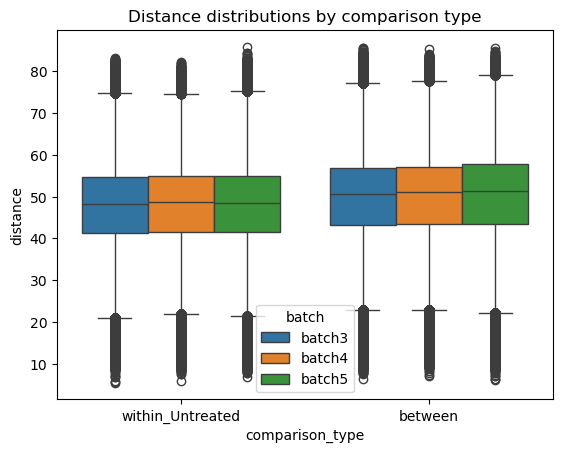

In [61]:
sns.boxplot(data=results_df, x='comparison_type', y='distance',hue='batch')
plt.title('Distance distributions by comparison type')
plt.show()

In [63]:
stat_results = pd.read_csv('/home/projects/hornsteinlab/Collaboration/MOmaps_Noam/MOmaps/tools/stats_dnls.csv', index_col=0)

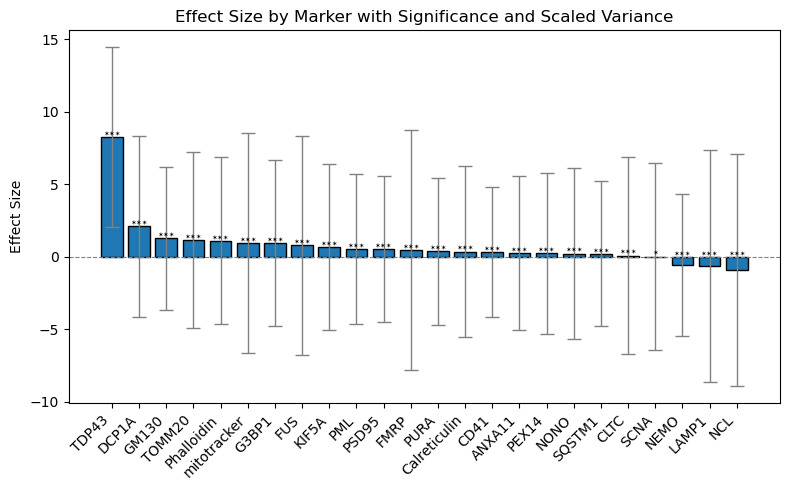

In [145]:
from statsmodels.stats.multitest import multipletests

stat_results['pvalue'] = stat_results['pvalue'].replace(0, 1e-300)  # avoid log(0)
_, adj_pvals, _, _ = multipletests(stat_results['pvalue'], method='fdr_bh')
stat_results['adj_pval'] = adj_pvals

stat_results = stat_results.sort_values('effect_size', ascending=False).reset_index(drop=True)

# Step 2: Scale batch_var to match effect_size range
# We'll scale the error bars to the max effect size for visibility
scale_factor = stat_results['effect_size'].max() / stat_results['batch_var'].max()
stat_results['scaled_error'] = stat_results['batch_var'] * scale_factor

# Step 3: Add significance stars
def get_stars(p):
    if p < 1e-4:
        return '\u2736\u2736\u2736'
    elif p < 1e-3:
        return '\u2736\u2736'
    elif p < 0.05:
        return '\u2736'
    else:
        return ''

stat_results['stars'] = stat_results['adj_pval'].apply(get_stars)

# Step 4: Plot
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(stat_results))
bars = ax.bar(x, stat_results['effect_size'], yerr=stat_results['scaled_error'], capsize=5, edgecolor='k',
                 error_kw=dict(lw=1, capthick=1, ecolor='gray'))

# Add significance stars
for i, (height, star) in enumerate(zip(stat_results['effect_size'], stat_results['stars'])):
    if star:
        ax.text(i, height + 0.02 if height > 0 else 0, star, ha='center', va='bottom', fontsize=5, color='black')

# Aesthetics
ax.set_xticks(x)
ax.set_xticklabels(stat_results['marker'], rotation=45, ha='right')
ax.set_ylabel("Effect Size")
ax.set_title("Effect Size by Marker with Significance and Scaled Variance")
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

In [81]:
import torch
from src.models.architectures.NOVA_model import NOVAModel
from src.models.utils.consts import CHECKPOINT_BEST_FILENAME, CHECKPOINTS_FOLDERNAME


In [82]:
# torch.load()
outputs_folder_path = '/home/projects/hornsteinlab/Collaboration/MOmaps/outputs/vit_models/finetuned_model'
chkp_path = os.path.join(outputs_folder_path, CHECKPOINTS_FOLDERNAME, CHECKPOINT_BEST_FILENAME)
model = NOVAModel.load_from_checkpoint(chkp_path)

In [119]:
# chkp_path
# model.trainset_paths
t = torch.load(chkp_path)

In [93]:
t.keys()

dict_keys(['model_dict', 'optimizer_dict', 'epoch', 'trainer_config_dict', 'dataset_config_dict', 'model_config_dict', 'scaler_dict', 'avg_val_loss', 'best_avg_val_loss', 'early_stopping_counter', 'description', 'trainset_paths', 'trainset_labels', 'valset_paths', 'valset_labels', 'testset_paths', 'testset_labels', 'rng_state', 'cuda_rng_state'])

In [128]:
# t['trainset_paths'] = np.array([p.replace('/labs/', '/projects/') for p in t['trainset_paths']])
# t['valset_paths'] = np.array([p.replace('/labs/', '/projects/') for p in t['valset_paths']])
# t['testset_paths'] = np.array([p.replace('/labs/', '/projects/') for p in t['testset_paths']])
t['testset_paths']

array(['/home/projects/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/batch8/FUSRevertant/Untreated/PSD95/rep2_R11_w3confCy5_s1531_panelD_FUSRevertant_processed.npy',
       '/home/projects/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/batch7/FUSHomozygous/Untreated/GM130/rep2_R11_w3confCy5_s923_panelF_FUSHomozygous_processed.npy',
       '/home/projects/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/batch8/TDP43/Untreated/CLTC/rep2_R11_w2confmCherry_s575_panelD_TDP43_processed.npy',
       ...,
       '/home/projects/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/batch8/TDP43/Untreated/NCL/rep1_R11_w3confCy5_s458_panelG_TDP43_processed.npy',
       '/home/projects/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/batch7/TBK1/Untreated/Calreticulin/rep1_R11_w3confCy5_s300_panelI_TBK1_processed.npy',
       '/home/projects/hornsteinlab/Collaboration/M

In [129]:
torch.save(t, chkp_path)

In [130]:
chkp_path

'/home/projects/hornsteinlab/Collaboration/MOmaps/outputs/vit_models/finetuned_model/checkpoints/checkpoint_best.pth'